In [36]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings("ignore")

In [37]:
# reading the file
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

In [38]:
# displaying the top 5 rows of the dataset.
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [39]:
TARGET_CATEGORIES = ["POLITICS", "BUSINESS", "SPORTS"]
RECORDS_PER_CATEGORY = 5000
RANDOM_SEED = 42

# Converting the category names to all caps for filtering
df['category'] = df['category'].str.upper()

# Filter and sample 5,000 records for each of the three categories
sampled_dfs = []
for category in TARGET_CATEGORIES:
    df_category = df[df['category'] == category]

    # Sample the required number of records
    df_sampled = df_category.sample(n=RECORDS_PER_CATEGORY, random_state=RANDOM_SEED)
    sampled_dfs.append(df_sampled)

# Concatenating the sampled DataFrames and select only the required columns
df_final = pd.concat(sampled_dfs, ignore_index=True)
df_final = df_final[['headline', 'category']]

# Shuffling the final DataFrame
df_final = df_final.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# The resulting balanced DataFrame with 15,000 records is stored in df_final
print(f"Final DataFrame shape: {df_final.shape}")
print(df_final.head())

Final DataFrame shape: (15000, 2)
                                            headline  category
0  Houston Astros On The Brink Of World Series Cr...    SPORTS
1  Why My Toaster Loves My Car: Are You Ready for...  BUSINESS
2                                      Et Tu, Media?    SPORTS
3            Sarah Palin's Excuse For Speeding Is...  POLITICS
4               Yogi Berra and the Greek Debt Crisis  BUSINESS


#### The final balanced dataset of 15,000 records by filtering and sampling 5,000 headlines from each of the three target categories before shuffling the final DataFrame. The same records from Assignment 2

In [40]:
# Checking for any missing values
df_final.isnull().sum()

,0
headline,0
category,0


In [41]:
from sklearn.model_selection import train_test_split

# Separate features (X) and labels (y)
X = df_final['headline']
y = df_final['category']

# X_train is 70% (10,500 records)
# X_test is 20% (3,000 records)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.20,      # 20% for testing (3,000 records)
    stratify=y,          # To Maintain class balance
    random_state=42)

# The test_size is set to be 0.125 (10% / 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.125,     # 10% of total (1,500 records)
    stratify=y_train_val, # Maintain class balance
    random_state=42)

# Final check of sizes
print(f"Training Set (70%): {len(X_train)} records")
print(f"Validation Set (10%): {len(X_val)} records")
print(f"Testing Set (20%): {len(X_test)} records")

Training Set (70%): 10500 records
Validation Set (10%): 1500 records
Testing Set (20%): 3000 records


 #### Spliting the 15,000-record final dataset into a 20% testing set (3,000 records), 70% training set (10,500 records) and 10% validation set (1500 records) while ensuring the class balance is maintained using stratification.

In [42]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TRANSFORMERS_NO_TF'] = '1'

In [43]:
import torch
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [44]:
from datasets import Dataset

# Checking the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


### Preparing the Data for DistilBERT

In [45]:
# Creating label mapping
label_mapping = {'BUSINESS': 0, 'POLITICS': 1, 'SPORTS': 2}
id_to_label = {0: 'BUSINESS', 1: 'POLITICS', 2: 'SPORTS'}

# Converting labels to integers
y_train_int = y_train.map(label_mapping)
y_val_int = y_val.map(label_mapping)
y_test_int = y_test.map(label_mapping)

# Creating datasets in HuggingFace format
train_dataset = Dataset.from_dict({
    'text': X_train.tolist(),
    'label': y_train_int.tolist()
})

val_dataset = Dataset.from_dict({
    'text': X_val.tolist(),
    'label': y_val_int.tolist()
})

test_dataset = Dataset.from_dict({
    'text': X_test.tolist(),
    'label': y_test_int.tolist()
})

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 10500
Validation samples: 1500
Test samples: 3000


### Tokenization

In [46]:
# Initializing tokenizer (using Fast tokenizer for better performance)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=64  # Headlines are short, so 64 is sufficient
    )

# Tokenizing datasets
print("Tokenizing training data...")
train_tokenized = train_dataset.map(tokenize_function, batched=True)
print("Tokenizing validation data...")
val_tokenized = val_dataset.map(tokenize_function, batched=True)
print("Tokenizing test data...")
test_tokenized = test_dataset.map(tokenize_function, batched=True)

# Setting format for PyTorch
train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("Tokenization complete!")

Tokenizing training data...


Map:   0%|          | 0/10500 [00:00<?, ? examples/s]

Tokenizing validation data...


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Tokenizing test data...


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Tokenization complete!


### MODEL 1: Fine-tune Only Classification Head

In [47]:
# Loading the pre-trained model
model1 = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    id2label=id_to_label,
    label2id=label_mapping
)

# Freezing all parameters except classification head
print("\nFreezing parameters")
for name, param in model1.named_parameters():
    if 'classifier' not in name:  # Freeze everything except classifier
        param.requires_grad = False
    else:
        param.requires_grad = True
        print(f"  Trainable: {name}, Shape: {param.shape}")

# Counting trainable parameters
trainable_params_1 = sum(p.numel() for p in model1.parameters() if p.requires_grad)
total_params_1 = sum(p.numel() for p in model1.parameters())
print(f"\nTotal parameters: {total_params_1:,}")
print(f"Trainable parameters: {trainable_params_1:,}")
print(f"Percentage trainable: {100 * trainable_params_1 / total_params_1:.4f}%")

# Defining compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Defining training arguments
training_args_1 = TrainingArguments(
    output_dir='./results_model1',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-4,  # Higher learning rate for head-only training
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    logging_dir='./logs_model1',
    logging_steps=50,
    save_total_limit=2,
    seed=42,
    report_to='none',

)

# Initializing Trainer
trainer_1 = Trainer(
    model=model1,
    args=training_args_1,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Training Model 1
print("\nStarting training for Model 1")
start_time_1 = time.time()
train_result_1 = trainer_1.train()
train_time_1 = time.time() - start_time_1

print(f"Model 1 training completed!")
print(f"Training time: {train_time_1:.2f} seconds ({train_time_1/60:.2f} minutes)")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Freezing parameters
  Trainable: pre_classifier.weight, Shape: torch.Size([768, 768])
  Trainable: pre_classifier.bias, Shape: torch.Size([768])
  Trainable: classifier.weight, Shape: torch.Size([3, 768])
  Trainable: classifier.bias, Shape: torch.Size([3])

Total parameters: 66,955,779
Trainable parameters: 592,899
Percentage trainable: 0.8855%

Starting training for Model 1


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.379000,0.373015,0.866000,0.868001,0.866000,0.866479
2,0.333400,0.359523,0.868667,0.870666,0.868667,0.868728
3,0.346900,0.345960,0.875333,0.875813,0.875333,0.874996
4,0.369600,0.377900,0.852667,0.866753,0.852667,0.853843
5,0.349400,0.335787,0.874000,0.874436,0.874000,0.873534
6,0.351100,0.332425,0.881333,0.882572,0.881333,0.881606
7,0.312400,0.333016,0.880000,0.881263,0.880000,0.879854
8,0.303700,0.330654,0.879333,0.879743,0.879333,0.878890
9,0.316700,0.323414,0.887333,0.887379,0.887333,0.887192
10,0.300700,0.322316,0.890000,0.889994,0.890000,0.889874


Model 1 training completed!
Training time: 66.17 seconds (1.10 minutes)


### MODEL 2: Fine-tune All Except Embeddings

In [48]:
# Loading the pre-trained model
model2 = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    id2label=id_to_label,
    label2id=label_mapping
)

# Freezing only embeddings
print("\nFreezing embeddings")
frozen_count = 0
trainable_count = 0
for name, param in model2.named_parameters():
    if 'embeddings' in name:  # Freeze only embeddings
        param.requires_grad = False
        frozen_count += 1
    else:
        param.requires_grad = True
        trainable_count += 1

print(f"Frozen layers: {frozen_count}")
print(f"Trainable layers: {trainable_count}")

# Counting trainable parameters
trainable_params_2 = sum(p.numel() for p in model2.parameters() if p.requires_grad)
total_params_2 = sum(p.numel() for p in model2.parameters())
print(f"\nTotal parameters: {total_params_2:,}")
print(f"Trainable parameters: {trainable_params_2:,}")
print(f"Percentage trainable: {100 * trainable_params_2 / total_params_2:.4f}%")

# Defining training arguments
training_args_2 = TrainingArguments(
    output_dir='./results_model2',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,  # Lower learning rate for full fine-tuning
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    logging_dir='./logs_model2',
    logging_steps=50,
    save_total_limit=2,
    seed=42,
    report_to='none',
)

# Initializing Trainer
trainer_2 = Trainer(
    model=model2,
    args=training_args_2,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Training Model 2
print("\nStarting training for Model 2")
start_time_2 = time.time()
train_result_2 = trainer_2.train()
train_time_2 = time.time() - start_time_2

print(f"Model 2 training completed!")
print(f"Training time: {train_time_2:.2f} seconds ({train_time_2/60:.2f} minutes)")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Freezing embeddings
Frozen layers: 4
Trainable layers: 100

Total parameters: 66,955,779
Trainable parameters: 43,120,131
Percentage trainable: 64.4009%

Starting training for Model 2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.287200,0.279185,0.912667,0.913799,0.912667,0.912764
2,0.188700,0.276849,0.916000,0.915946,0.916000,0.915736
3,0.140300,0.299744,0.912000,0.912587,0.912000,0.912029
4,0.131000,0.373586,0.904667,0.905896,0.904667,0.904746
5,0.059500,0.393502,0.906667,0.906717,0.906667,0.906559


Model 2 training completed!
Training time: 74.65 seconds (1.24 minutes)


### Evaluation on Test Set

In [49]:
def evaluate_model(trainer, test_data, model_name):
    """Evaluate model and return metrics"""
    print(f"Evaluating {model_name}")

    # Measuring inference time
    start_time = time.time()
    predictions = trainer.predict(test_data)
    inference_time = time.time() - start_time

    # Getting predictions
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    # Converting to category names
    pred_categories = [id_to_label[label] for label in pred_labels]
    true_categories = [id_to_label[label] for label in true_labels]

    # Classification report
    report = classification_report(
        true_categories,
        pred_categories,
        target_names=['BUSINESS', 'POLITICS', 'SPORTS'],
        output_dict=True,
        zero_division=0
    )

    # Displaying results
    print(f"\n{model_name} - Per-Class Metrics:")
    df_report = pd.DataFrame(report).transpose()
    print(df_report.loc[['BUSINESS', 'POLITICS', 'SPORTS'],
                        ['precision', 'recall', 'f1-score']].to_string())

    # Micro averages
    micro_avg = report['accuracy']
    print(f"\nMicro Averages:")
    print(f"  Precision: {micro_avg:.4f}")
    print(f"  Recall:    {micro_avg:.4f}")
    print(f"  F1-score:  {micro_avg:.4f}")

    # Macro averages
    print(f"\nMacro Averages:")
    print(f"  Precision: {report['macro avg']['precision']:.4f}")
    print(f"  Recall:    {report['macro avg']['recall']:.4f}")
    print(f"  F1-score:  {report['macro avg']['f1-score']:.4f}")

    print(f"\nInference time: {inference_time:.4f} seconds")
    print(f"Time per sample: {inference_time/len(test_data)*1000:.2f} ms")

    return report, pred_categories, true_categories, inference_time, df_report

# Evaluating both models
report_1, pred_1, true_1, inf_time_1, df_report_1 = evaluate_model(
    trainer_1, test_tokenized, "Model 1 (Classification Head Only)"
)

report_2, pred_2, true_2, inf_time_2, df_report_2 = evaluate_model(
    trainer_2, test_tokenized, "Model 2 (All Except Embeddings)"
)

Evaluating Model 1 (Classification Head Only)



Model 1 (Classification Head Only) - Per-Class Metrics:
          precision  recall  f1-score
BUSINESS   0.861272   0.894  0.877331
POLITICS   0.886316   0.842  0.863590
SPORTS     0.909091   0.920  0.914513

Micro Averages:
  Precision: 0.8853
  Recall:    0.8853
  F1-score:  0.8853

Macro Averages:
  Precision: 0.8856
  Recall:    0.8853
  F1-score:  0.8851

Inference time: 1.2457 seconds
Time per sample: 0.42 ms
Evaluating Model 2 (All Except Embeddings)



Model 2 (All Except Embeddings) - Per-Class Metrics:
          precision  recall  f1-score
BUSINESS   0.894841   0.902  0.898406
POLITICS   0.905252   0.879  0.891933
SPORTS     0.937316   0.957  0.947056

Micro Averages:
  Precision: 0.9127
  Recall:    0.9127
  F1-score:  0.9127

Macro Averages:
  Precision: 0.9125
  Recall:    0.9127
  F1-score:  0.9125

Inference time: 1.2527 seconds
Time per sample: 0.42 ms


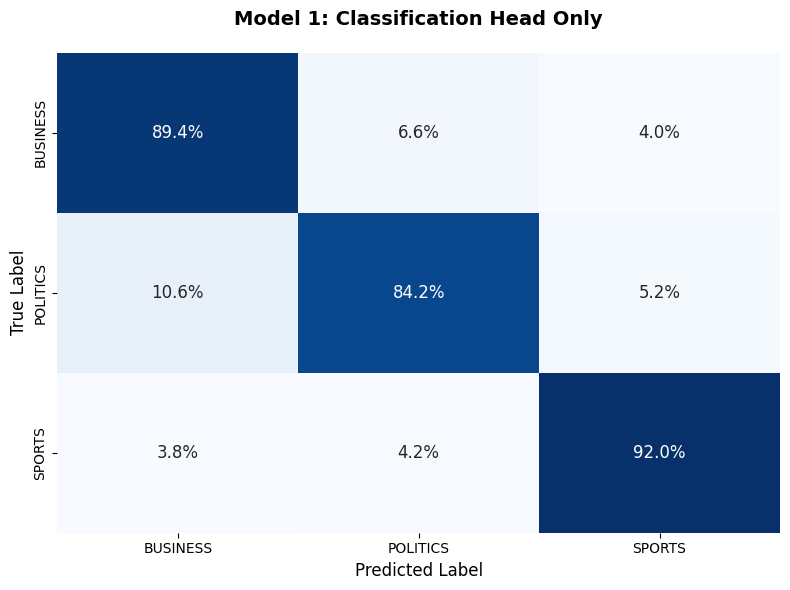

In [50]:
def plot_confusion_matrix(true_labels, pred_labels, title):
    """Plot confusion matrix as percentages"""
    cm = confusion_matrix(true_labels, pred_labels,
                         labels=['BUSINESS', 'POLITICS', 'SPORTS'],
                         normalize='true') * 100

    cm_labels = [[f"{value:.1f}%" for value in row] for row in cm]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=cm_labels, fmt="", cmap="Blues",
                xticklabels=['BUSINESS', 'POLITICS', 'SPORTS'],
                yticklabels=['BUSINESS', 'POLITICS', 'SPORTS'],
                cbar=False, annot_kws={"size": 12})

    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.tight_layout()
    plt.show()

# Plotting confusion matrices
plot_confusion_matrix(true_1, pred_1, "Model 1: Classification Head Only")

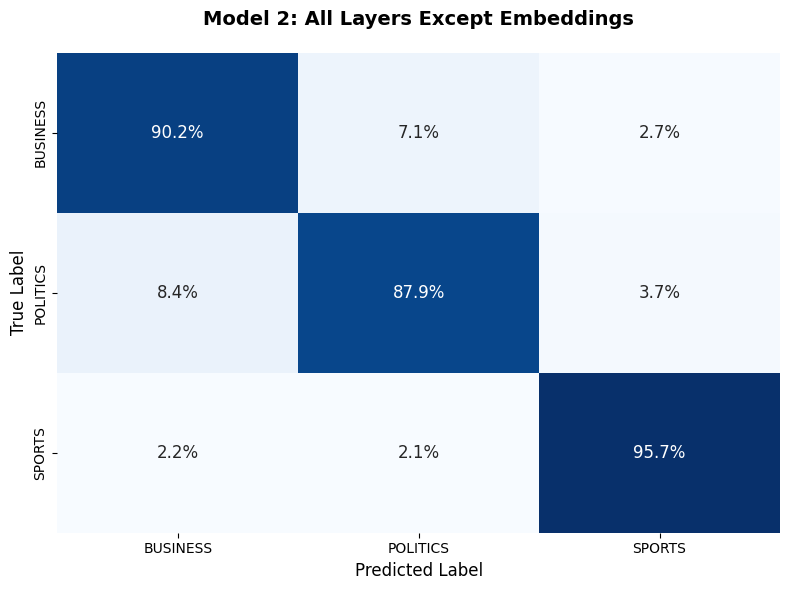

In [51]:
plot_confusion_matrix(true_2, pred_2, "Model 2: All Layers Except Embeddings")

### Per-Class Metrics Visualization

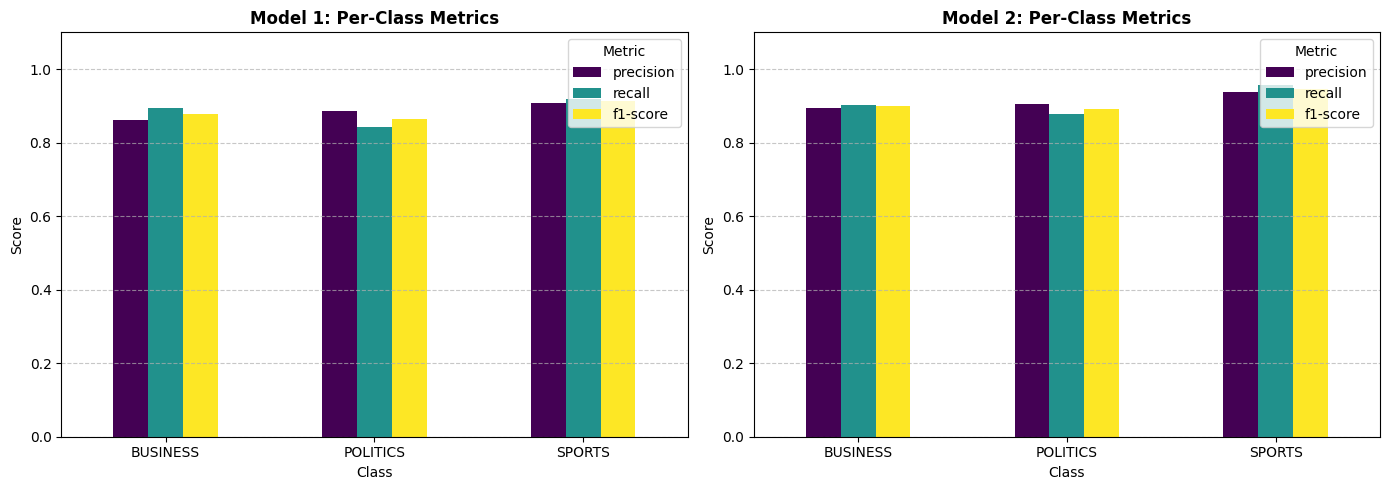

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Model 1
metrics_1 = df_report_1.loc[['BUSINESS', 'POLITICS', 'SPORTS'], ['precision', 'recall', 'f1-score']]
metrics_1.plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Model 1: Per-Class Metrics', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Class')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].set_ylim(0, 1.1)
axes[0].legend(title='Metric')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Model 2
metrics_2 = df_report_2.loc[['BUSINESS', 'POLITICS', 'SPORTS'], ['precision', 'recall', 'f1-score']]
metrics_2.plot(kind='bar', ax=axes[1], colormap='viridis')
axes[1].set_title('Model 2: Per-Class Metrics', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].set_xlabel('Class')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].set_ylim(0, 1.1)
axes[1].legend(title='Metric')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Comparison with Assignment 2 Models

In [53]:
comparison_data = {
    'Model': [
        '1. FFN Classifier',
        '2. RNN (GRU)',
        '3. RNN (LSTM)',
        '4. DistilBERT (Head Only)',
        '5. DistilBERT (Full)'
    ],
    'Macro Precision': [
        0.8020,  # Assignment 2 FFN result
        0.8321,  # Assignment 2 GRU result
        0.8397,  # Assignment 2 LSTM result
        report_1['macro avg']['precision'],
        report_2['macro avg']['precision']
    ],
    'Macro Recall': [
        0.8017,  # Assignment 2 FFN result
        0.8293,  # Assignment 2 GRU result
        0.8397,  # Assignment 2 LSTM result
        report_1['macro avg']['recall'],
        report_2['macro avg']['recall']
    ],
    'Macro F1-Score': [
        0.8015,  # Assignment 2 FFN result
        0.8282,  # Assignment 2 GRU result
        0.8396,  # Assignment 2 LSTM result
        report_1['macro avg']['f1-score'],
        report_2['macro avg']['f1-score']
    ],
    'Training Time (min)': [
        0.08,  # from Assignment 2 (5 epochs * ~1s)
        5.0,   # from Assignment 2 (10 epochs * ~3s)
        5.5,   # from Assignment 2 (11 epochs * ~3s)
        train_time_1 / 60,
        train_time_2 / 60
    ],
    'Inference Time (s)': [
        0.5,   # Estimate for Assignment 2 FFN
        1.0,   # Estimate for Assignment 2 GRU
        1.5,   # Estimate for Assignment 2 LSTM
        inf_time_1,
        inf_time_2
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison Table:")
print(df_comparison.to_string(index=False))


Model Performance Comparison Table:
                    Model  Macro Precision  Macro Recall  Macro F1-Score  Training Time (min)  Inference Time (s)
        1. FFN Classifier         0.802000      0.801700        0.801500             0.080000            0.500000
             2. RNN (GRU)         0.832100      0.829300        0.828200             5.000000            1.000000
            3. RNN (LSTM)         0.839700      0.839700        0.839600             5.500000            1.500000
4. DistilBERT (Head Only)         0.885559      0.885333        0.885144             1.102779            1.245721
     5. DistilBERT (Full)         0.912470      0.912667        0.912465             1.244088            1.252696


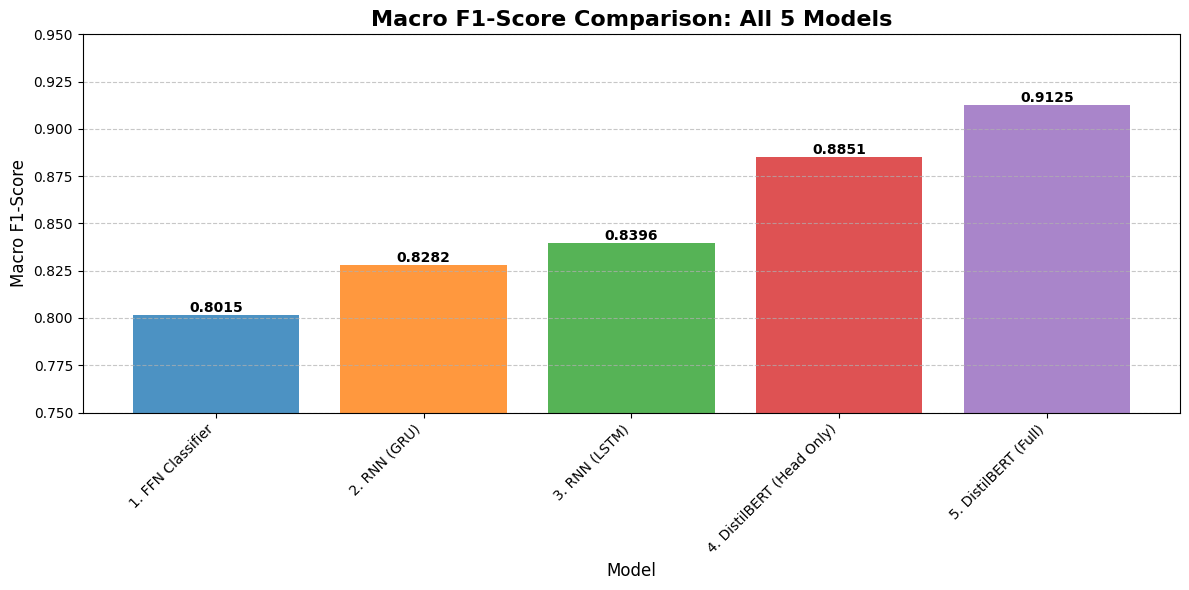

In [54]:
# Plot 1: F1-Score Comparison
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = plt.bar(df_comparison['Model'], df_comparison['Macro F1-Score'], color=colors, alpha=0.8)
plt.title('Macro F1-Score Comparison: All 5 Models', fontsize=16, fontweight='bold')
plt.ylabel('Macro F1-Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.75, 0.95)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('f1_score_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

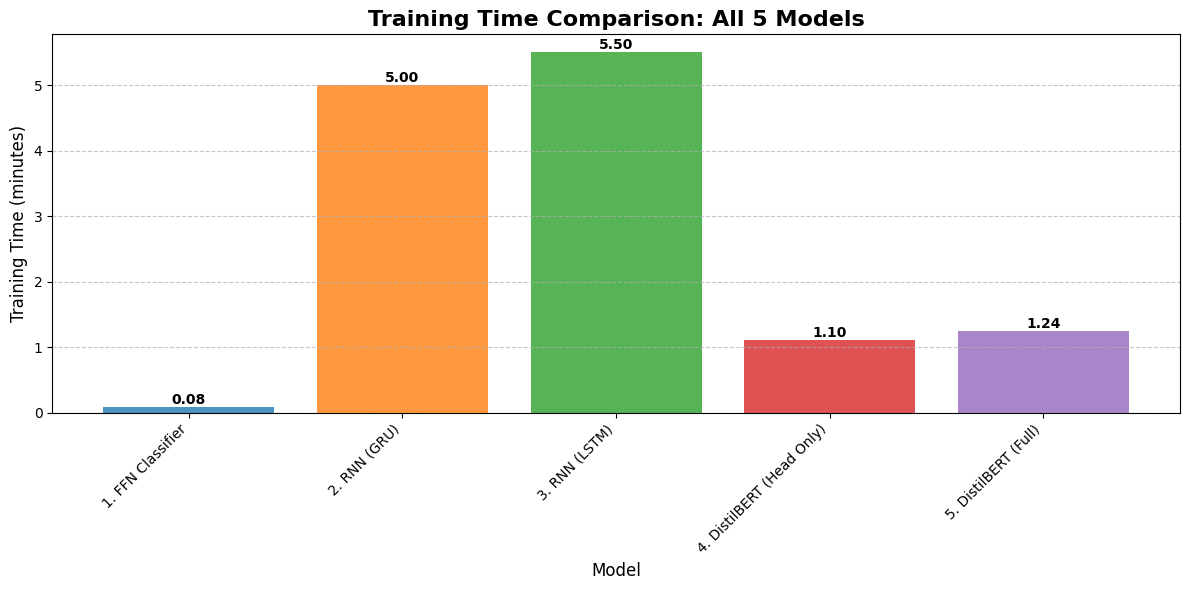

In [55]:
# Plot 2: Training Time Comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(df_comparison['Model'], df_comparison['Training Time (min)'],
               color=colors, alpha=0.8)
plt.title('Training Time Comparison: All 5 Models', fontsize=16, fontweight='bold')
plt.ylabel('Training Time (minutes)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('training_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

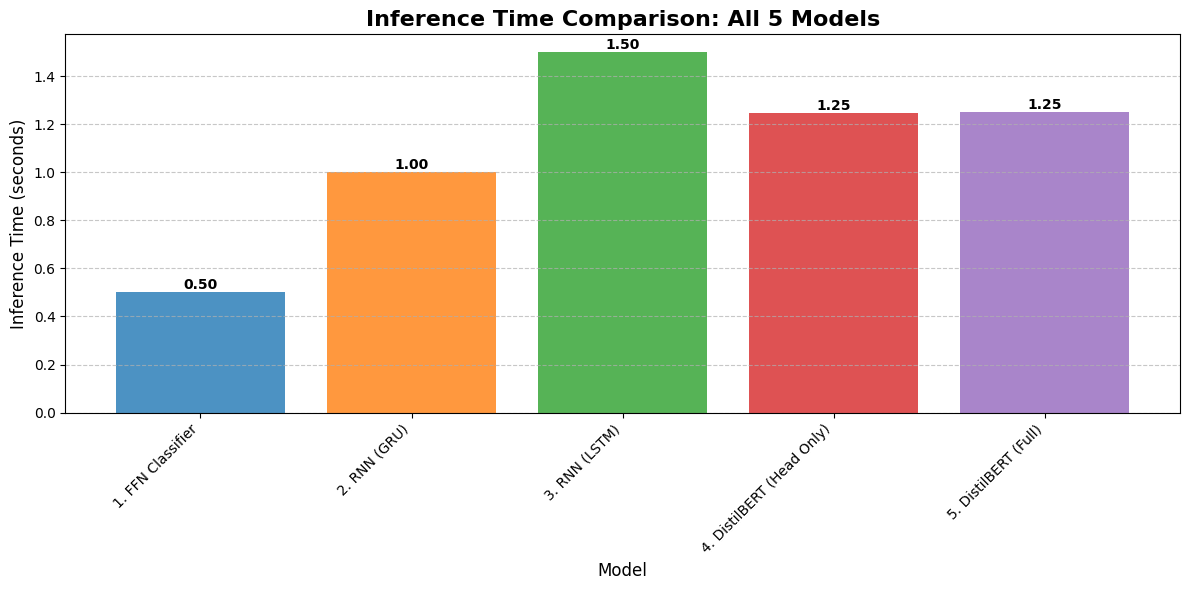

In [56]:
# Plot 3: Inference Time Comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(df_comparison['Model'], df_comparison['Inference Time (s)'],
               color=colors, alpha=0.8)
plt.title('Inference Time Comparison: All 5 Models', fontsize=16, fontweight='bold')
plt.ylabel('Inference Time (seconds)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('inference_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Per-Class F1-Score Comparison

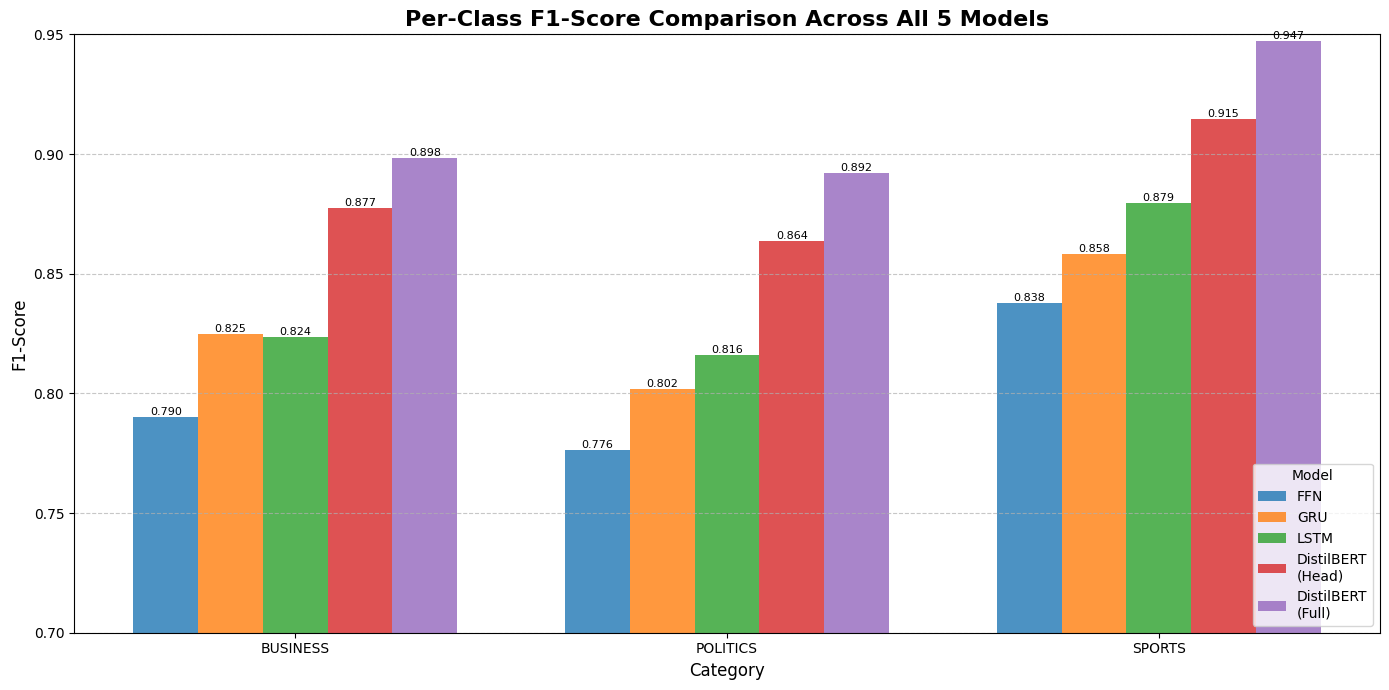

In [57]:
per_class_data = {
    'BUSINESS': [
        0.7902,  # Assignment 2 FFN
        0.8246,  # Assignment 2 GRU
        0.8235,  # Assignment 2 LSTM
        report_1['BUSINESS']['f1-score'],
        report_2['BUSINESS']['f1-score']
    ],
    'POLITICS': [
        0.7764,  # Assignment 2 FFN
        0.8019,  # Assignment 2 GRU
        0.8159,  # Assignment 2 LSTM
        report_1['POLITICS']['f1-score'],
        report_2['POLITICS']['f1-score']
    ],
    'SPORTS': [
        0.8379,  # Assignment 2 FFN
        0.8582,  # Assignment 2 GRU
        0.8794,  # Assignment 2 LSTM
        report_1['SPORTS']['f1-score'],
        report_2['SPORTS']['f1-score']
    ]
}

categories = ['BUSINESS', 'POLITICS', 'SPORTS']
models = ['FFN', 'GRU', 'LSTM', 'DistilBERT\n(Head)', 'DistilBERT\n(Full)']

x = np.arange(len(categories))
width = 0.15

fig, ax = plt.subplots(figsize=(14, 7))

for i, model in enumerate(models):
    values = [per_class_data[cat][i] for cat in categories]
    bars = ax.bar(x + i*width, values, width, label=model, color=colors[i], alpha=0.8)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score Comparison Across All 5 Models',
             fontsize=16, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(categories)
ax.legend(title='Model', loc='lower right', fontsize=10)
ax.set_ylim(0.7, 0.95)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('per_class_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
best_f1_idx = df_comparison['Macro F1-Score'].idxmax()
fastest_train_idx = df_comparison['Training Time (min)'].idxmin()
fastest_inference_idx = df_comparison['Inference Time (s)'].idxmin()

print("\n KEY FINDINGS:")
print(f"\n1. BEST PERFORMANCE (F1-Score):")
print(f"   Model: {df_comparison.loc[best_f1_idx, 'Model']}")
print(f"   F1-Score: {df_comparison.loc[best_f1_idx, 'Macro F1-Score']:.4f}")
print(f"   Precision: {df_comparison.loc[best_f1_idx, 'Macro Precision']:.4f}")
print(f"   Recall: {df_comparison.loc[best_f1_idx, 'Macro Recall']:.4f}")

print(f"\n2. FASTEST TRAINING:")
print(f"   Model: {df_comparison.loc[fastest_train_idx, 'Model']}")
print(f"   Training Time: {df_comparison.loc[fastest_train_idx, 'Training Time (min)']:.2f} minutes")

print(f"\n3. FASTEST INFERENCE:")
print(f"   Model: {df_comparison.loc[fastest_inference_idx, 'Model']}")
print(f"   Inference Time: {df_comparison.loc[fastest_inference_idx, 'Inference Time (s)']:.2f} seconds")

# Performance improvement analysis
baseline_f1 = df_comparison.loc[0, 'Macro F1-Score']
distilbert_full_f1 = df_comparison.loc[4, 'Macro F1-Score']
improvement = ((distilbert_full_f1 - baseline_f1) / baseline_f1) * 100

print(f"\n4. IMPROVEMENT OVER BASELINE:")
print(f"   DistilBERT (Full) vs FFN: {improvement:+.2f}%")


 KEY FINDINGS:

1. BEST PERFORMANCE (F1-Score):
   Model: 5. DistilBERT (Full)
   F1-Score: 0.9125
   Precision: 0.9125
   Recall: 0.9127

2. FASTEST TRAINING:
   Model: 1. FFN Classifier
   Training Time: 0.08 minutes

3. FASTEST INFERENCE:
   Model: 1. FFN Classifier
   Inference Time: 0.50 seconds

4. IMPROVEMENT OVER BASELINE:
   DistilBERT (Full) vs FFN: +13.84%
